In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scipy.io as sio
import pandas as pd
from matplotlib import pyplot as plt 
from matplotlib import cm
import numpy as np
from numpy import ma
from scipy.linalg import eig
from datetime import datetime
import pytz
from matplotlib import colors
import matplotlib
import seaborn as sns
plt.rcParams['figure.dpi'] = 300
from Asymptotic import select_asymptotic
import xarray as xr
from Turbulence_processing.Scaling.Anisotropy import Anisotropy

In [3]:
cmap = plt.get_cmap('Set2')
color = dict(
    red = cmap(1),
    blue = cmap(2),
    yellow = cmap(5)
)

In [4]:
#Load data
Dataset_name = 'MetCrax'

data_1 = xr.open_dataset('../../Dataset/'+ Dataset_name + '/' + Dataset_name +'_unprocessed_stable.nc')
data_30 = xr.open_dataset('../../Dataset/'+ Dataset_name + '/' + Dataset_name +'_unprocessed_unstable.nc')

In [5]:
#Compute anisotropy

barycentric_1, components_1, eigenvalues_1, eigenvectors_1 = Anisotropy(data_1, return_rotation = True)
barycentric_30, components_30, eigenvalues_30, eigenvectors_30 = Anisotropy(data_30, return_rotation = True)

#aspect ratio
data_1 = data_1.assign( Ar = data_1.ww/(data_1.uu+data_1.vv))

In [6]:
#save in dataset
data_1 = data_1.assign(
    tke = (data_1.uu + data_1.vv + data_1.ww) * 0.5,
    yb = (['time', 'heights'],barycentric_1[1]),
    xb = (['time', 'heights'],barycentric_1[0]),
    components = (['time', 'heights','comp'], components_1),
    eigenvalues = (['eigidx','time', 'heights'], eigenvalues_1),
    eigenvectors = (['xyz','eigidx','time', 'heights'], eigenvectors_1),
)
data_1 = data_1.assign(beta = (np.pi*0.5 - np.arccos(data_1.eigenvectors.isel({'xyz' : 0, 'eigidx' : 2}))) / np.pi * 180)

data_30 = data_30.assign(
    tke = (data_30.uu + data_30.vv + data_30.ww) * 0.5,
    yb = (['time', 'heights'],barycentric_30[1]),
    xb = (['time', 'heights'],barycentric_30[0]),
    components = (['time', 'heights','comp'],components_30),
    eigenvalues = (['eigidx','time', 'heights'], eigenvalues_30),
    eigenvectors = (['xyz','eigidx','time', 'heights'], eigenvectors_30),
)
data_30 = data_30.assign(beta = (np.pi*0.5 - np.arccos(data_30.eigenvectors.isel({'xyz' : 0, 'eigidx' : 2}))) / np.pi * 180)

In [7]:
# ANGLES OF EIGENVECTORS

#extract eigenvectros components
vx = data_1.eigenvectors.isel(xyz = 0)
vy = data_1.eigenvectors.isel(xyz = 1)
vz = data_1.eigenvectors.isel(xyz = 2)

#longitudinal angle
phi = np.arctan2(vy,vx)
#latitudinal angle
theta = np.arccos(vz)

#save back to dataset
data_1 = data_1.assign(
    phi = phi * 180 /np.pi,
    theta = theta * 180 /np.pi
)

#30 min
#extract eigenvectros components
vx = data_30.eigenvectors.isel(xyz = 0)
vy = data_30.eigenvectors.isel(xyz = 1)
vz = data_30.eigenvectors.isel(xyz = 2)

#longitudinal angle
phi = np.arctan2(vy,vx)
#latitudinal angle
theta = np.arccos(vz)

#save back to dataset
data_30 = data_30.assign(
    phi = phi * 180 /np.pi,
    theta = theta * 180 /np.pi
)


In [8]:
#compute stability
#unstable
L = -data_30.ustar ** 3 * data_30.meanT / (0.4 * 9.81 * data_30.wT)
Z = (data_30.heights / L).transpose()  #transpose to have time as first dim
data_30 = data_30.assign(
    zeta=(['time', 'heights'], np.abs(Z.data)),
)
#stable
L = -data_1.ustar ** 3 * data_1.meanT / (0.4 * 9.81 * data_1.wT)
Z = (data_1.heights / L).transpose()  #transpose to have time as first dim
data_1 = data_1.assign(
    zeta=(['time', 'heights'], Z.data),
)

In [9]:
data_1 = data_1.where(data_1.wT < 0).dropna(dim = 'time', how = 'any')
data_30 = data_30.where(data_30.wT > 0).dropna(dim = 'time', how = 'any')

In [10]:
stable_1c = select_asymptotic(data_1, '1c')
stable_2c = select_asymptotic(data_1, '2c')
stable_3c = select_asymptotic(data_1, '3c')

unstable_1c = select_asymptotic(data_30, '1c')
unstable_2c = select_asymptotic(data_30, '2c')
unstable_3c = select_asymptotic(data_30, '3c')

In [11]:
stable_1c.to_netcdf(Dataset_name + '_stable_1c.nc')
stable_2c.to_netcdf(Dataset_name + '_stable_2c.nc')
stable_3c.to_netcdf(Dataset_name + '_stable_3c.nc')

unstable_1c.to_netcdf(Dataset_name + '_unstable_1c.nc')
unstable_2c.to_netcdf(Dataset_name + '_unstable_2c.nc')
unstable_3c.to_netcdf(Dataset_name + '_unstable_3c.nc')

data_1.to_netcdf(Dataset_name + '_stable_1m.nc')
data_30.to_netcdf(Dataset_name + '_unstable_30m.nc')

Text(0, 0.5, '$y_b$')

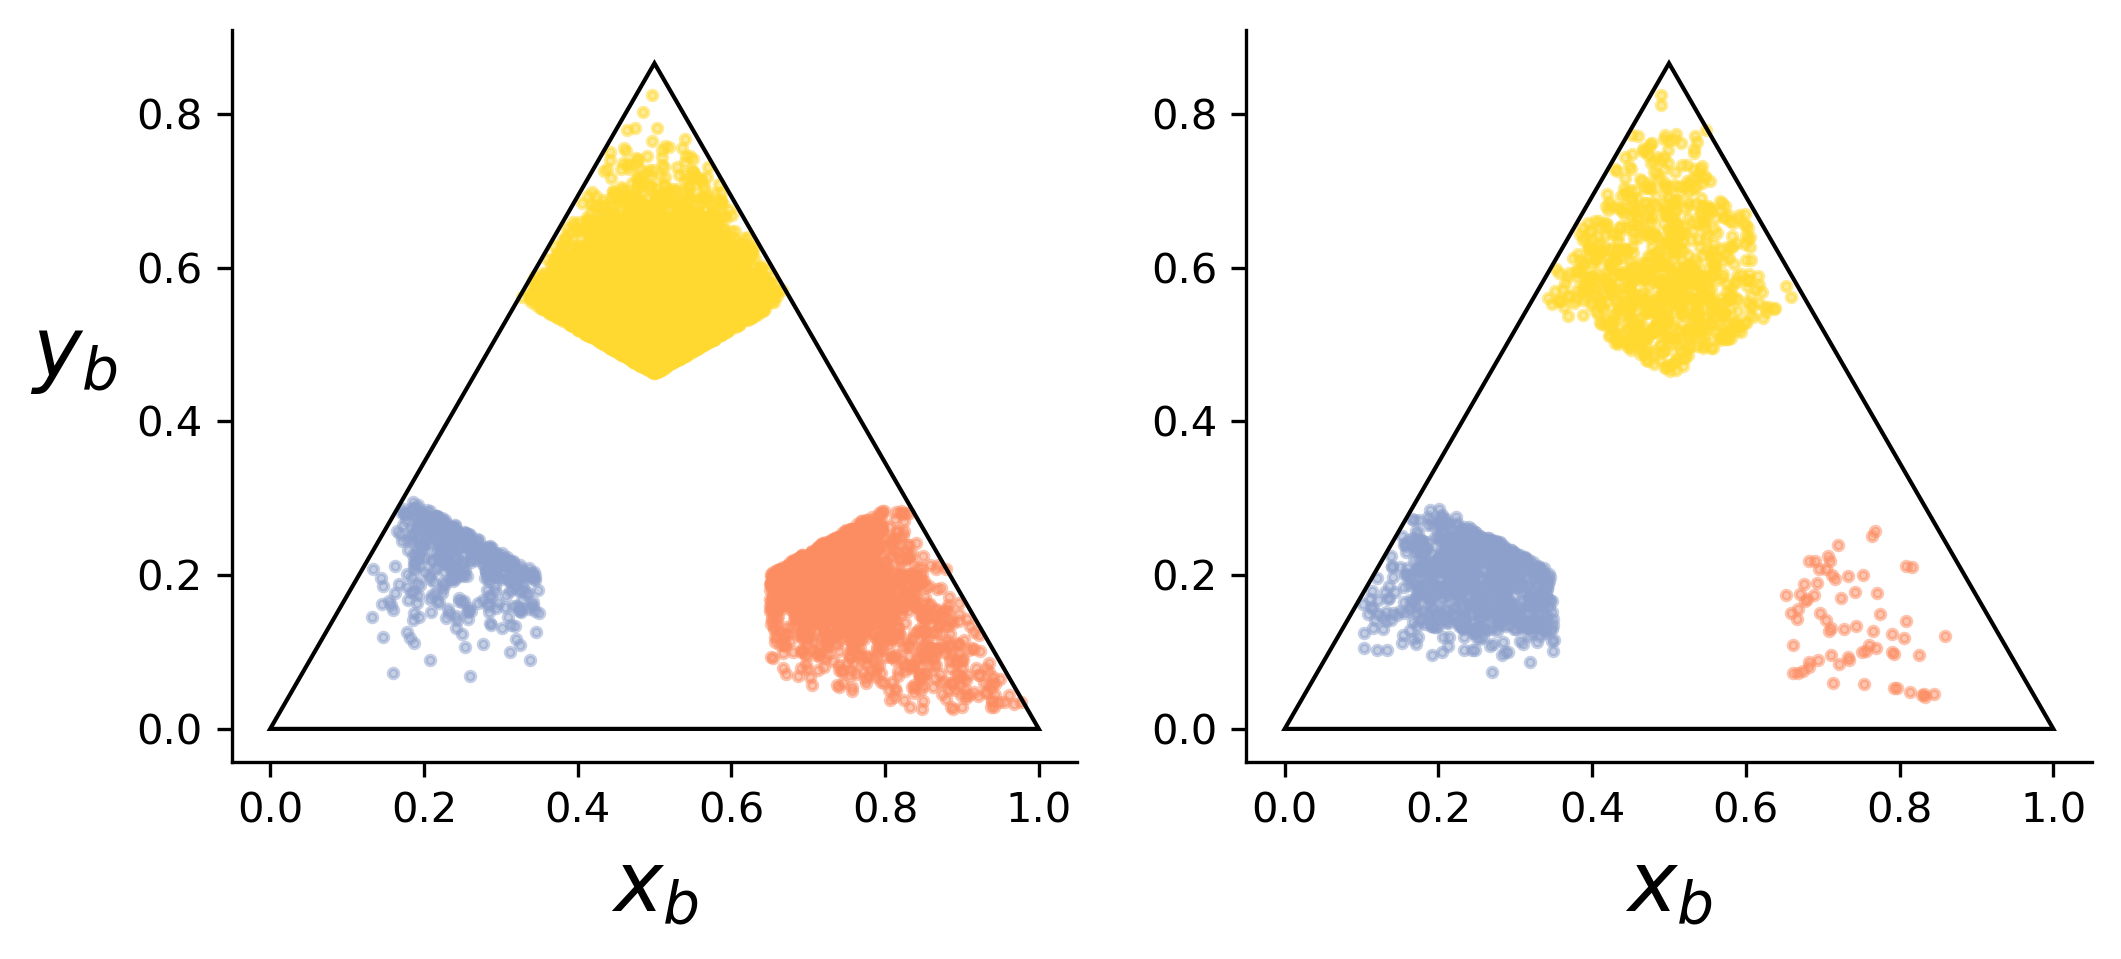

In [15]:
#plot figure
fig,axs = plt.subplots(1,2,figsize = (8,8))

#draw lines
vertices = np.array([[0,0],[1,0],[0.5,np.sqrt(3)/2]])

for ax in axs:
    triangle=matplotlib.patches.Polygon(vertices,closed=True,fill=False,color='black')
    ax.add_patch(triangle)
    sns.despine(ax=ax, offset=0)
    ax.set_aspect('equal')
    ax.set_xlabel(r'$x_b$', fontsize=20)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(10)
            
axs[0].scatter(stable_1c.xb, stable_1c.yb, alpha = 0.5, s=5, color = color['red'])
axs[0].scatter(stable_2c.xb, stable_2c.yb, alpha = 0.5, s=5, color = color['blue'])
axs[0].scatter(stable_3c.xb, stable_3c.yb, alpha = 0.5, s=5, color = color['yellow'])

axs[1].scatter(unstable_1c.xb, unstable_1c.yb, alpha = 0.5, s=5, color = color['red'])
axs[1].scatter(unstable_2c.xb, unstable_2c.yb, alpha = 0.5, s=5, color = color['blue'])
axs[1].scatter(unstable_3c.xb, unstable_3c.yb, alpha = 0.5, s=5, color = color['yellow'])


axs[0].set_ylabel(r'$y_b$', fontsize=20, rotation = 0, labelpad = 15)

(0.0, 44.0)

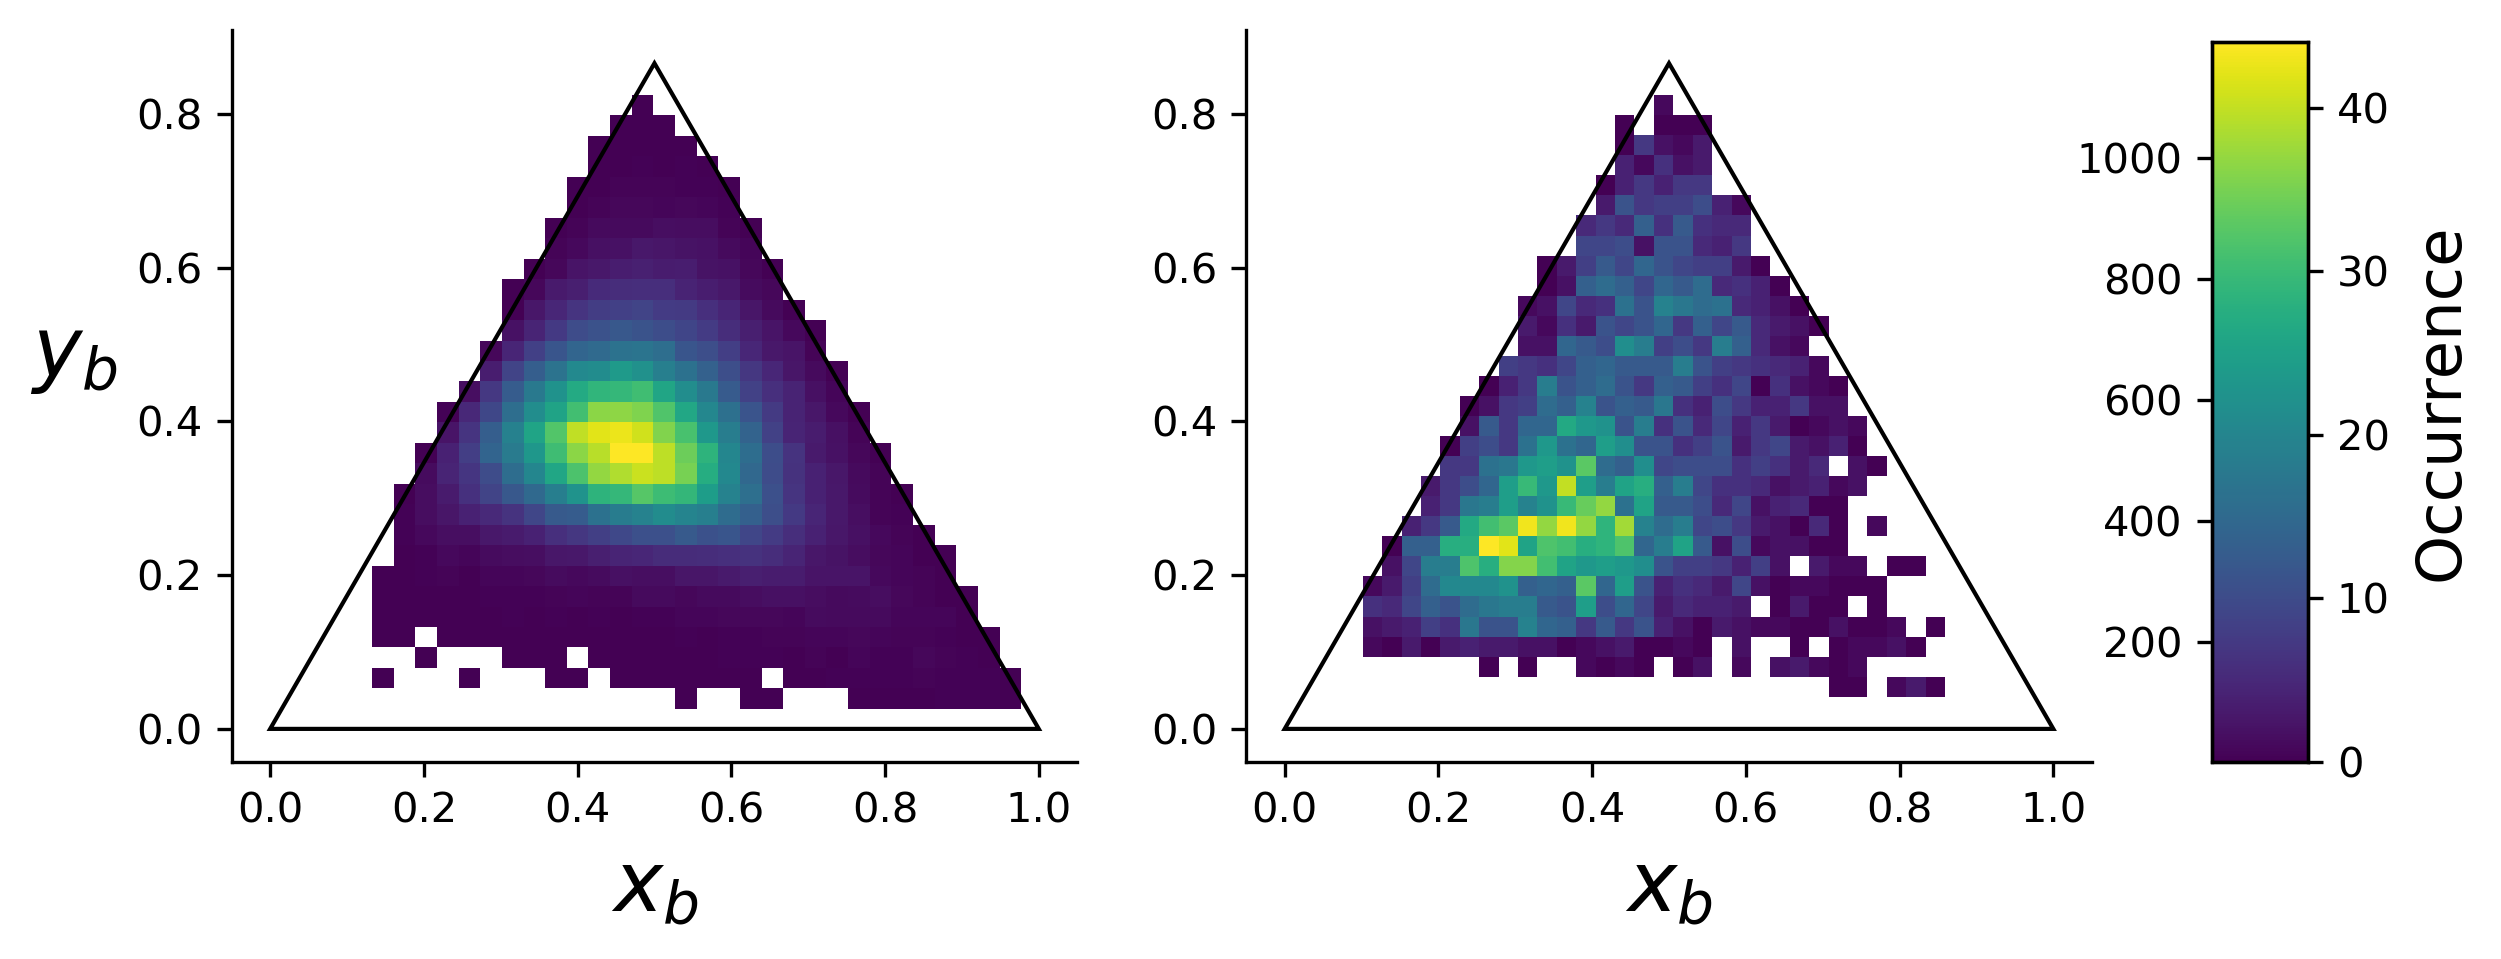

In [14]:
data_s = data_1.stack(index=('time','heights')).reset_index('index')
data_un = data_30.stack(index=('time','heights')).reset_index('index')

#plot figure
fig,axs = plt.subplots(1,2,figsize = (8,8))

#draw lines
vertices=np.array([[0,0],[1,0],[0.5,np.sqrt(3)/2]])

for ax in axs:
    triangle=matplotlib.patches.Polygon(vertices,closed=True,fill=False,color='black')
    ax.add_patch(triangle)
    sns.despine(ax=ax, offset=0)
    ax.set_aspect('equal')
    ax.set_xlabel(r'$x_b$', fontsize=20)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(10)

H, yedges, xedges = np.histogram2d(data_s.yb, data_s.xb, bins=30)
H[H==0.0] = np.nan
pc_1 = axs[0].pcolormesh(xedges, yedges, H, cmap='viridis')

H, yedges, xedges = np.histogram2d(data_un.yb, data_un.xb, bins=30)
H[H==0.0] = np.nan
pc_2 = axs[1].pcolormesh(xedges, yedges, H, cmap='viridis')

axs[0].set_ylabel(r'$y_b$', fontsize=20, rotation = 0, labelpad = 15)


cbar_ax = fig.add_axes([0.95,0.35, 0.04, 0.3]) 
cax2 = cbar_ax.twinx()

cbar = fig.colorbar(pc_1, cax=cbar_ax)
cbar.set_label(label='Occurrence',fontsize=15, labelpad = 25)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('right')
# adjust limits of right axis to match data range of 3rd plot
cax2.set_ylim(0,np.nanmax(H))
